In [7]:
import numpy as np
from extract_ros2_data import extract_data_from_bag
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
bag_path = '../2024_10_29/test_08'
gps_datum = np.array([12.99300425860631, 80.23913114094384, 94.0])
imu_data, gps_data, odom_data = extract_data_from_bag(bag_path, gps_datum)

print("IMU Data:")
for topic, data in imu_data.items():
    print(f"Topic: {topic}")
    for key, value in data.items():
        print(f"  {key}: {value.shape}")

print("\nGPS Data:")
for topic, data in gps_data.items():
    print(f"Topic: {topic}")
    for key, value in data.items():
        print(f"  {key}: {value.shape}")

print("\nOdometry Data:")
for topic, data in odom_data.items():
    print(f"Topic: {topic}")
    for key, value in data.items():
        print(f"  {key}: {value.shape}")

[INFO] [1732424323.824250587] [rosbag2_storage]: Opened database '../2024_10_29/test_08/test_08_0.db3' for READ_ONLY.


IMU Data:
Topic: /imu/data
  time: (33149,)
  ang_vel: (33149, 3)
  acc: (33149, 3)
  quat: (33149, 4)
  eul: (33149, 3)

GPS Data:
Topic: /ublox_gps_node/fix
  time: (328,)
  lla: (328, 3)
  ned: (328, 3)

Odometry Data:
Topic: /kurma_00/odometry
  time: (3088,)
  pos: (3088, 3)
  quat: (3088, 4)
  eul: (3088, 3)
  lin_vel: (3088, 3)
  ang_vel: (3088, 3)


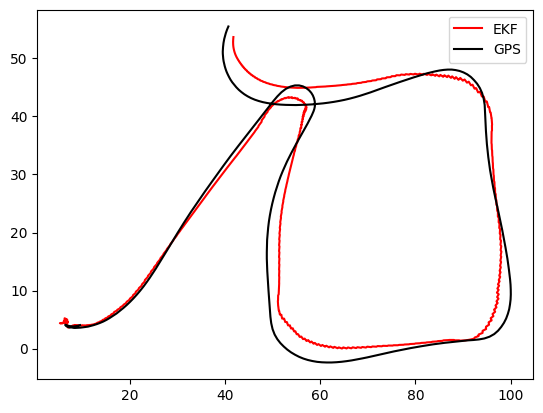

In [3]:
plt.figure()
plt.plot(odom_data["/kurma_00/odometry"]["pos"][:, 0], odom_data["/kurma_00/odometry"]["pos"][:, 1], 'r', label='EKF')
plt.plot(gps_data["/ublox_gps_node/fix"]["ned"][:, 0], gps_data["/ublox_gps_node/fix"]["ned"][:, 1], 'k', label='GPS')
plt.legend()
plt.grid()
plt.show()

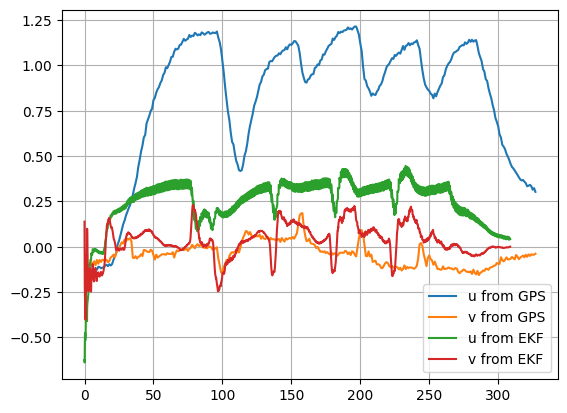

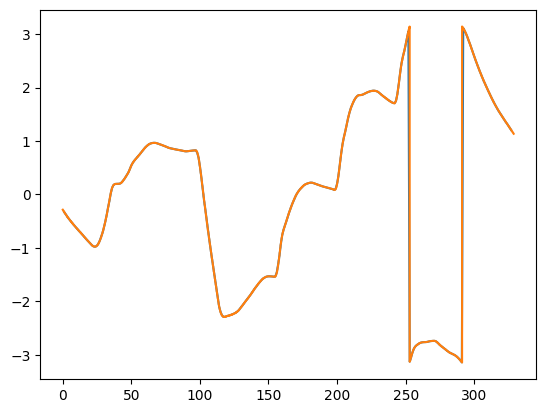

In [8]:
x_gps = gps_data["/ublox_gps_node/fix"]["ned"][:, 0]
y_gps = gps_data["/ublox_gps_node/fix"]["ned"][:, 1]
t_gps = gps_data["/ublox_gps_node/fix"]["time"]

t_gps_new = t_gps[1:]
x_gps_new = x_gps[1:]
y_gps_new = y_gps[1:]

xd_gps_new = np.diff(x_gps)/np.diff(t_gps)
yd_gps_new = np.diff(y_gps)/np.diff(t_gps)

t_imu = imu_data["/imu/data"]["time"]
psi_imu = imu_data["/imu/data"]["eul"][:, 2] * np.pi / 180.0

t_imu = t_imu - t_imu[0]
t_gps_new = t_gps_new - t_gps[0]

psi_interp = np.interp(t_gps_new, t_imu, psi_imu)
u_gps = xd_gps_new * np.cos(psi_interp) + yd_gps_new * np.sin(psi_interp)
v_gps = -xd_gps_new * np.sin(psi_interp) + yd_gps_new * np.cos(psi_interp)

t_odom = odom_data["/kurma_00/odometry"]["time"]
u_odom = odom_data["/kurma_00/odometry"]["lin_vel"][:, 0]
v_odom = odom_data["/kurma_00/odometry"]["lin_vel"][:, 1]

t_odom = t_odom - t_odom[0]

plt.figure()
plt.plot(t_gps_new, u_gps, label='u from GPS')
plt.plot(t_gps_new, v_gps, label='v from GPS')
plt.plot(t_odom, u_odom, label='u from EKF')
plt.plot(t_odom, v_odom, label='v from EKF')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t_gps_new, psi_interp,'b',label='HeadGPS')
plt.plot(t_imu, psi_imu)
plt.grid()